```
This software is part of GPU Ocean. 

Copyright (C) 2017-2023 SINTEF Digital
Copyright (C) 2017-2023 Norwegian Meteorological Institute

This notebooks shows Monte Carlo realisations of the doublejet example

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Double Jet

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

In [2]:
from gpuocean.utils import Common, IPythonMagic

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
from gpuocean.utils import DoubleJetCase

doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState)
doubleJetCase_args, doubleJetCase_init = doubleJetCase.getInitConditions()

In [5]:
from gpuocean.ensembles import OceanModelEnsemble
from gpuocean.utils import Observation

In [6]:
doubleJetCase_args.pop("gpu_ctx")

In [7]:
import copy
data_args = copy.deepcopy(doubleJetCase_args)
data_args.update(doubleJetCase_init)

In [8]:
ensemble = OceanModelEnsemble.OceanModelEnsemble(gpu_ctx, 
                                                 {},
                                                 data_args, 
                                                 3)

In [9]:
dim_x = doubleJetCase_args["dx"]*doubleJetCase_args["nx"]
dim_y = doubleJetCase_args["dy"]*doubleJetCase_args["ny"]

In [10]:
ensemble.attachDrifters(np.random.uniform((0, 0), (dim_x, dim_y), (100, 2)))

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\drifters\GPUDrifterCollection.py:74: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  defines={'block_width': self.block_width, 'block_height': self.block_height


In [11]:
def stepToObservation(ensemble, observation_time, progress_info=True, obs_dt=300):
    """
    Advance the ensemble to the given observation time, and mimics CDKLM16.dataAssimilationStep function
    
    Arguments:
        observation_time: The end time for the simulation 
    """
    ensemble_obs = []
    for p in range(ensemble.getNumParticles()):

        if ensemble.particles[p].hasDrifters:

            observation_args = {
                'nx': ensemble.particles[p].nx, 'ny': ensemble.particles[p].ny,
                'domain_size_x': ensemble.particles[p].nx*ensemble.particles[p].dx,
                'domain_size_y': ensemble.particles[p].ny*ensemble.particles[p].dy,
                'land_mask': ensemble.particles[p].getLandMask()
               }

            obs = Observation.Observation(**observation_args)
            ensemble_obs.append(obs)
            obs.add_observation_from_sim(ensemble.particles[p])
    
        # Only active particles are evolved
        while ensemble.particles[p].t < observation_time - 0.001:
            ensemble.particles[p].dataAssimilationStep(np.minimum(ensemble.particles[p].t+obs_dt,observation_time))
            obs.add_observation_from_sim(ensemble.particles[p])

        if progress_info:
            print('Step done for particle ' + str(p))
        
    ensemble.t = observation_time

    return ensemble_obs

In [12]:
ensemble_obs = stepToObservation(ensemble, 5*24*3600)

Step done for particle 0
Step done for particle 1
Step done for particle 2


In [13]:
from importlib import reload
from gpuocean.utils import DrifterPlotHelper
reload(DrifterPlotHelper)

<module 'gpuocean.utils.DrifterPlotHelper' from 'C:\\Users\\havardh\\playground-win\\gpuocean\\havahol-gpuocean\\src\\gpuocean\\utils\\DrifterPlotHelper.py'>

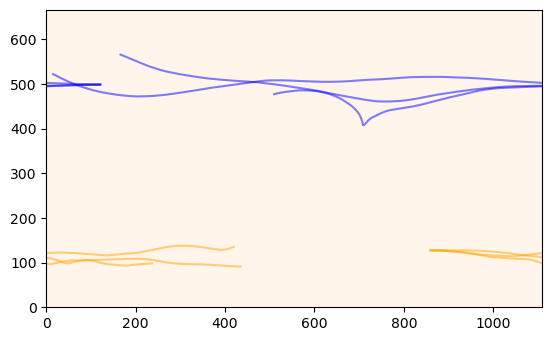

In [14]:
ax = DrifterPlotHelper.background_from_ensemble(ensemble)

DrifterPlotHelper.add_ensemble_drifter_on_background(ax, ensemble_obs, alpha=0.5)
DrifterPlotHelper.add_ensemble_drifter_on_background(ax, ensemble_obs, drifter_id=1,alpha=0.5, color="Orange")